In [125]:
import numpy as np
import pandas as pd
from k_means_constrained import KMeansConstrained
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

Creates the word embeddings from the pre-trained GloVE embedding file 

Estimated Time: 52 seconds

In [126]:
GLOVE_FILE = "glove.840B.300d.txt"
DIMS = 300

embeddings_index = {}
with open(GLOVE_FILE) as f:
    for line in f:
        splitted = line.split()
        word, coefs = " ".join(splitted[:len(splitted) - DIMS]), splitted[-DIMS:]
        coefs = np.array(coefs, dtype=float)
        embeddings_index[word] = coefs

In [127]:
CONNECTIONS_DATA = "connections.csv"
conn = pd.read_csv(CONNECTIONS_DATA, keep_default_na=False)
conn.iloc[664:668, :]

,0,1,2,3,clue
664,CO,MA,ME,PA,STATE ABBREVIATIONS
665,DO,FA,LA,TI,MUSICAL NOTES
666,MU,NU,PI,XI,GREEK LETTERS
667,FE,HE,NA,NI,PERIODIC TABLE SYMBOLS


Determines which words are not in the pre-trained embedding model

In [128]:
unk_words = set(word for word in conn.iloc[:, 0:4].to_numpy().flatten() if str(word).lower() not in embeddings_index)
valid = conn[~conn.iloc[:, 0:4].isin(unk_words).any(axis=1)]
valid

,0,1,2,3,clue
0,BIG,HOT,IN,POPULAR,OF-THE-MOMENT
1,CHARACTER,GLYPH,ICON,SYMBOL,PICTOGRAPH
2,ASSESS,CHARGE,FINE,LEVY,"IMPOSE, AS A PENALTY"
3,HANDSOME,HIPPO,LEGEND,LIPID,WORDS BEGINNING WITH BODY PARTS
4,CALCULATOR,CALENDAR,CAMERA,CLOCK,SMARTPHONE FEATURES BEGINNING WITH “C”
...,...,...,...,...,...
906,ESSENCE,PEOPLE,TIME,US,MAGAZINES
907,ARE,QUEUE,SEA,WHY,LETTER HOMOPHONES
908,HAIL,RAIN,SLEET,SNOW,WET WEATHER
909,BUCKS,HEAT,JAZZ,NETS,NBA TEAMS


Displaying the word from a Connections game and its corresponding word embedding

In [129]:
sample = conn.iloc[:, :4].to_numpy()
sets = np.array(np.array_split(sample, len(sample) // 4))
enc = sets.reshape((-1, 16))
enc = np.array([[embeddings_index.get(str(word).lower(), np.zeros((DIMS,))) for word in set] for set in enc])
(sets[0], enc[0])

(array([['BIG', 'HOT', 'IN', 'POPULAR'],
        ['CHARACTER', 'GLYPH', 'ICON', 'SYMBOL'],
        ['ASSESS', 'CHARGE', 'FINE', 'LEVY'],
        ['HANDSOME', 'HIPPO', 'LEGEND', 'LIPID']], dtype=object),
 array([[-0.37899  ,  0.041352 , -0.083947 , ..., -0.21303  ,  0.041024 ,
         -0.019819 ],
        [ 0.17453  , -0.11062  ,  0.34864  , ..., -0.52399  , -0.20693  ,
         -0.14813  ],
        [ 0.089187 ,  0.25792  ,  0.26282  , ...,  0.14421  , -0.169    ,
          0.26501  ],
        ...,
        [ 0.52797  , -0.11864  , -0.25654  , ...,  0.5289   ,  0.11001  ,
         -0.32933  ],
        [ 0.72341  , -0.042904 ,  0.19074  , ...,  0.30223  ,  0.58193  ,
         -0.03892  ],
        [-0.0047763, -0.076758 , -0.29663  , ..., -0.33801  ,  0.18916  ,
         -0.28818  ]]))

Performs K means constrianed clustering for all connections game and updates the metrics (used for visualizations later)

In [130]:
metrics = defaultdict(list)
for true_set, en in zip(sets, enc):
    clf = KMeansConstrained(
        n_clusters=4,
        size_min=4,
        size_max=4,
    )
    
    pred = clf.fit_predict(en)
    pred_set = [true_set.reshape((16,))[np.where(pred == i)] for i in range(0, 4)]
    true_set = set(frozenset(true) for true in true_set)
    pred_set = set(frozenset(pred) for pred in pred_set)
    metrics["correct_groups"].append(len(true_set.intersection(pred_set)))
    metrics["silhouette_score"].append(silhouette_score(en, pred))
    metrics["predicted"].append(pred)

Create histogram of the correct group accuracies from all the Connections games played

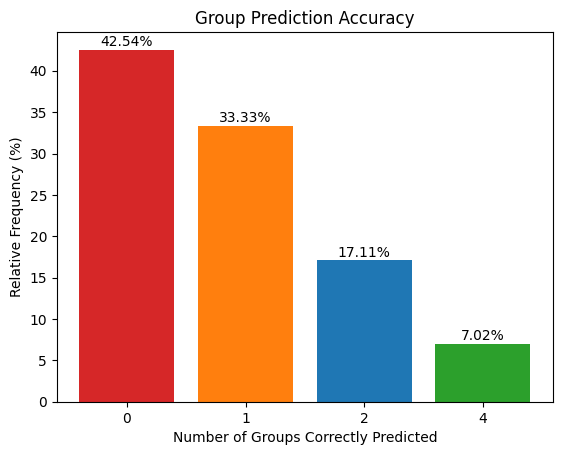

In [131]:
def visualize_group_prediction_accuracy(num_correct_groups):
    labels, counts = np.unique(num_correct_groups, return_counts=True)
    frequencies = counts / counts.sum()
    percentages = frequencies * 100
    colors = ['tab:red', 'tab:orange', 'tab:blue', 'tab:green']
    rects = plt.bar([str(l) for l in labels], percentages, color = colors)
    plt.bar_label(rects, padding = 0.5, labels = [f"{p:.2f}%" for p in percentages])
    plt.title("Group Prediction Accuracy")
    plt.xlabel("Number of Groups Correctly Predicted")
    plt.ylabel("Relative Frequency (%)")
    plt.savefig('./visualizations/glove-group-accuracies.png')

visualize_group_prediction_accuracy(metrics["correct_groups"])

Create histogram to visualize the silhouette scores from all the Connections games played

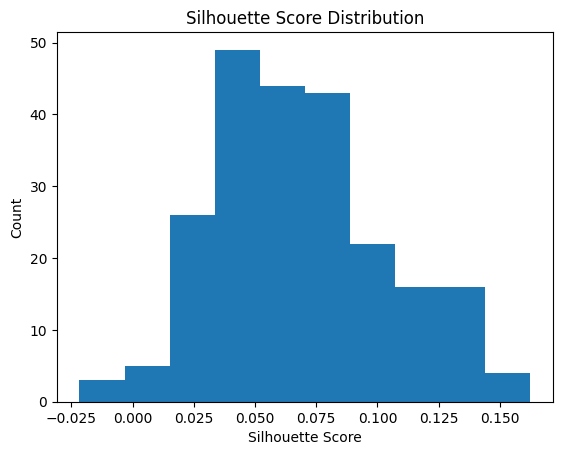

In [132]:
def visualize_silhouette_score(scores):
    plt.hist(scores)
    plt.title("Silhouette Score Distribution")
    plt.xlabel("Silhouette Score")
    plt.ylabel("Count")
    plt.savefig('./visualizations/glove-silhouette-scores.png')

visualize_silhouette_score(metrics["silhouette_score"])

Visualize the clusters created by one Connections game through dimensionality reduction 

Option of PCA or T-SNE

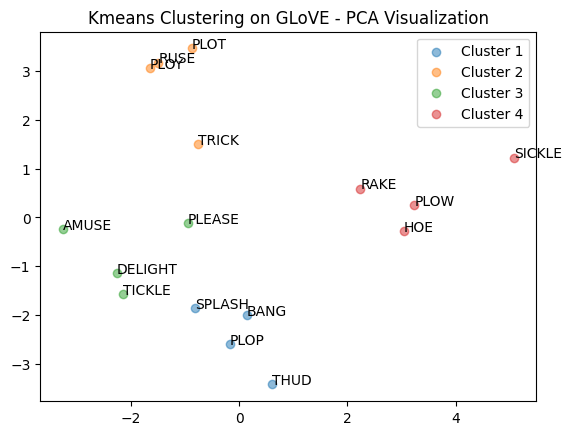

In [133]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def visualize_clusters(X, game, cluster_labels, reduction='pca'):
    if reduction == 'pca':
        pca = PCA(n_components=2)
        X_reduced = pca.fit_transform(X)
        plt.title('Kmeans Clustering on GLoVE - PCA Visualization')
    else:
        tsne = TSNE(perplexity=3)
        X_reduced = tsne.fit_transform(X)
        plt.title('Kmeans Clustering on GLoVE - T-SNE Visualization')

    for cluster_label in np.unique(cluster_labels):
        plt.scatter(X_reduced[cluster_labels == cluster_label, 0], X_reduced[cluster_labels == cluster_label, 1], 
        label=f'Cluster {cluster_label+1}', alpha=0.5)

    for i, word in enumerate(game.flatten()):
        plt.annotate(word, (X_reduced[i, 0], X_reduced[i, 1]))

    plt.legend()
    plt.savefig('./visualizations/glove-cluster-visualization.png')

EX_SET_IDX = metrics["correct_groups"].index(4)
ex_set, ex_enc = sets[EX_SET_IDX], enc[EX_SET_IDX]
pred = metrics["predicted"][EX_SET_IDX]
visualize_clusters(ex_enc, ex_set, pred)

Performs K-means constrained clustering on a sample Connections Game

In [134]:
clf = KMeansConstrained(
    n_clusters=4,
    size_min=4,
    size_max=4,
)
pred = clf.fit_predict(en)
ex_set = [sets[0].reshape((16))[np.where(pred == i)] for i in range(0, 4)]
ex_set

[array(['ICON', 'ASSESS', 'LEVY', 'LIPID'], dtype=object),
 array(['GLYPH', 'CHARGE', 'FINE', 'HIPPO'], dtype=object),
 array(['CHARACTER', 'SYMBOL', 'HANDSOME', 'LEGEND'], dtype=object),
 array(['BIG', 'HOT', 'IN', 'POPULAR'], dtype=object)]

In [135]:
np.all([set in sets[0] for set in ex_set])

True